# Histopathologic Cancer Detection

In [14]:
!pip install tensorflow pandas matplotlib seaborn scikit-learn

import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print('TensorFlow version:', tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 5.0 MB/s  0:00:01m 5.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 5.1 MB/s  0:00:04a 0:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn]0m 3/4 [scikit-learn]
TensorFlow version: 2.16.2


In [5]:
# Reproducibility helpers
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

# Adjust this base directory if you're running locally
BASE_DIR = Path('.')
TRAIN_DIR = BASE_DIR / 'train'
TEST_DIR = BASE_DIR / 'test'
LABELS_PATH = BASE_DIR / 'train_labels.csv'

assert TRAIN_DIR.exists(), f"Train directory not found: {TRAIN_DIR}"
assert LABELS_PATH.exists(), f"Labels file not found: {LABELS_PATH}"

# Image configuration
IMG_HEIGHT = 96
IMG_WIDTH = 96
IMG_CHANNELS = 3
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# Training configuration (you can tweak these later)
BATCH_SIZE = 64
EPOCHS = 10  # start small; increase later
VAL_FRACTION = 0.15
TEST_FRACTION = 0.05  # we will keep a small holdout set


## 1. Data Overview & Basic EDA

In [6]:
# Load labels
labels_df = pd.read_csv(LABELS_PATH)
print('Labels shape:', labels_df.shape)
labels_df.head()

Labels shape: (220025, 2)


id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB

Label distribution:
label
0    130908
1     89117
Name: count, dtype: int64


/var/folders/jh/4kwqbjsd3dgbfb4ln4903s8r0000gn/T/ipykernel_7590/2610053994.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(['Benign (0)', 'Metastatic (1)'])


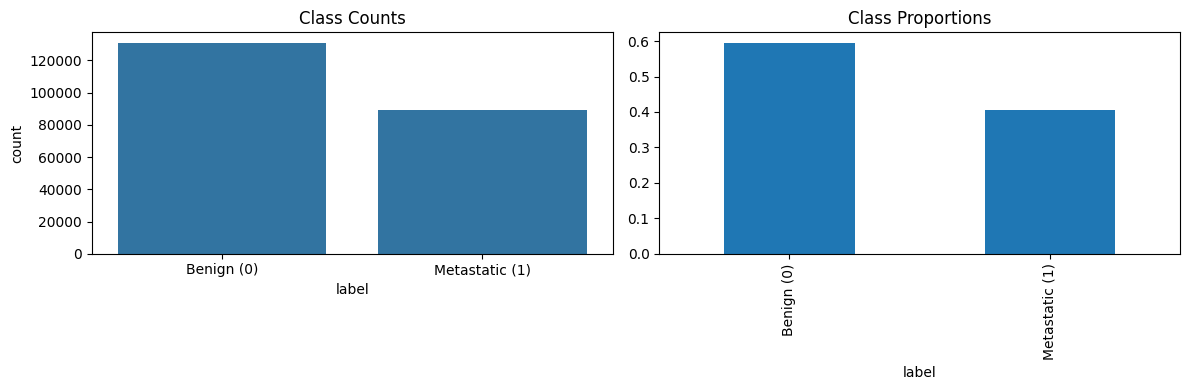

In [7]:
# Basic info about the labels
labels_df.info()

print('\nLabel distribution:')
print(labels_df['label'].value_counts())

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(data=labels_df, x='label', ax=ax[0])
ax[0].set_title('Class Counts')
ax[0].set_xticklabels(['Benign (0)', 'Metastatic (1)'])

labels_df['label'].value_counts(normalize=True).plot(kind='bar', ax=ax[1])
ax[1].set_title('Class Proportions')
ax[1].set_xticklabels(['Benign (0)', 'Metastatic (1)'])

plt.tight_layout()
plt.show()

Sample image shape: (96, 96, 3)


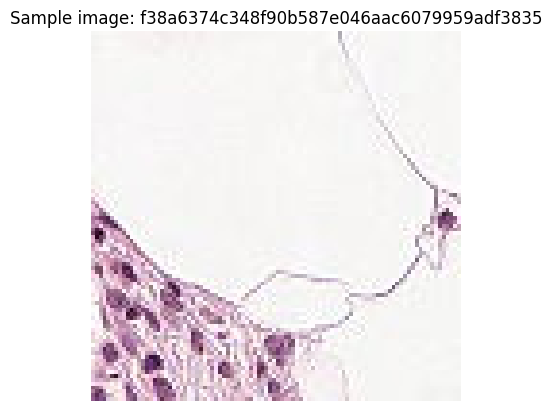

In [8]:
sample_id = labels_df.iloc[0]['id']
sample_path = TRAIN_DIR / f"{sample_id}.tif"
with Image.open(sample_path) as img:
    arr = np.array(img)
print('Sample image shape:', arr.shape)

plt.imshow(arr)
plt.title(f'Sample image: {sample_id}')
plt.axis('off')
plt.show()

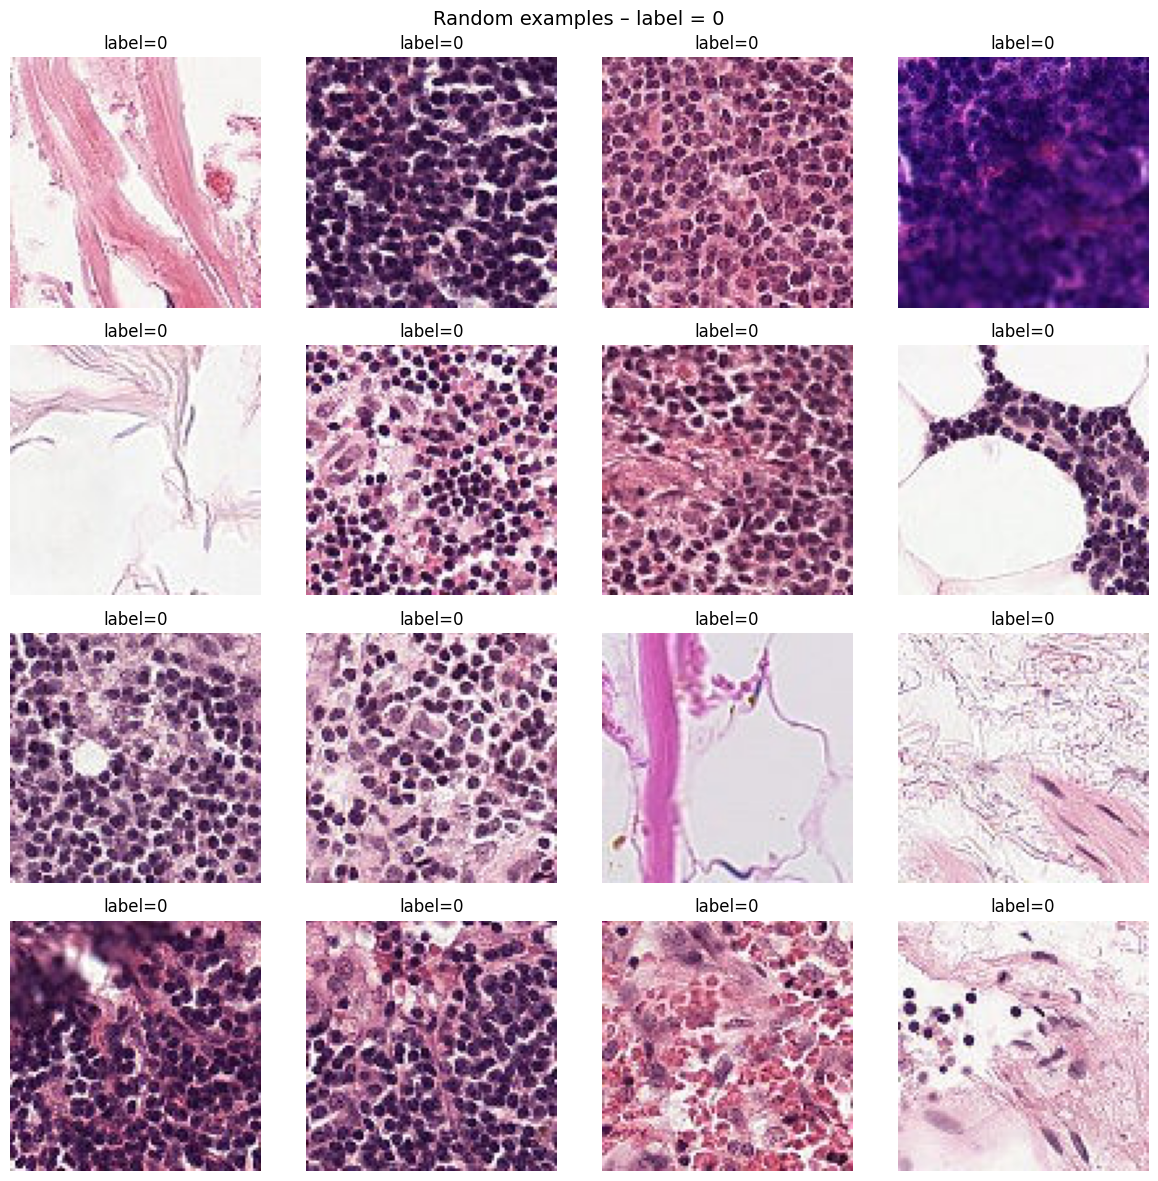

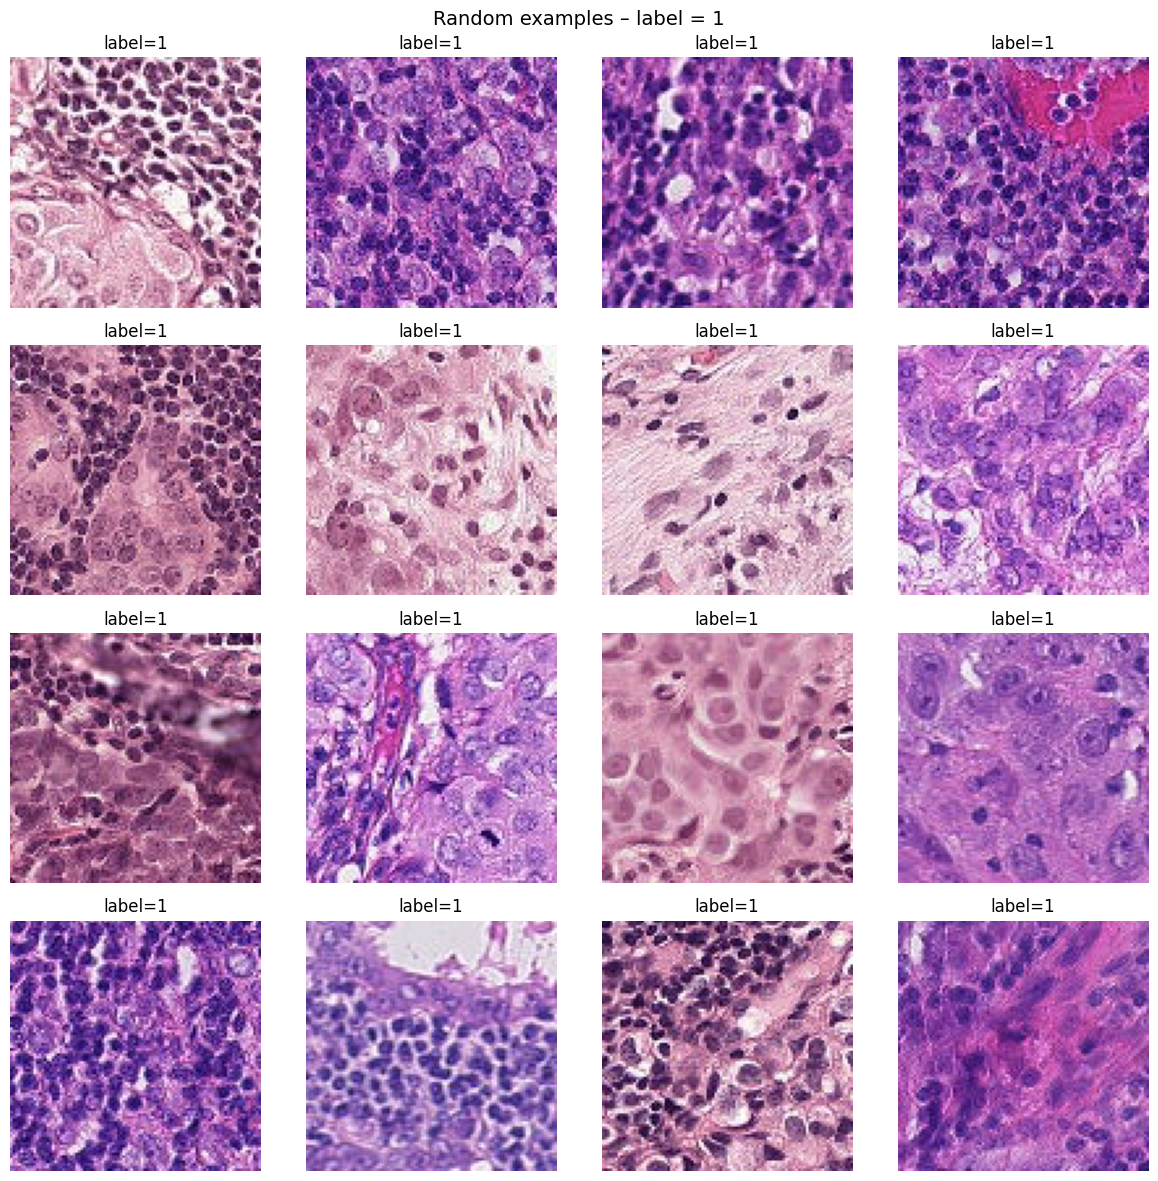

In [9]:
def show_random_images(df, label, n=16):
    subset = df[df['label'] == label].sample(n)
    n_cols = 4
    n_rows = n // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    axes = axes.ravel()
    for ax, (_, row) in zip(axes, subset.iterrows()):
        img_path = TRAIN_DIR / f"{row['id']}.tif"
        with Image.open(img_path) as img:
            ax.imshow(img)
        ax.set_title(f"label={label}")
        ax.axis('off')
    plt.suptitle(f'Random examples – label = {label}', fontsize=14)
    plt.tight_layout()
    plt.show()

show_random_images(labels_df, label=0)
show_random_images(labels_df, label=1)

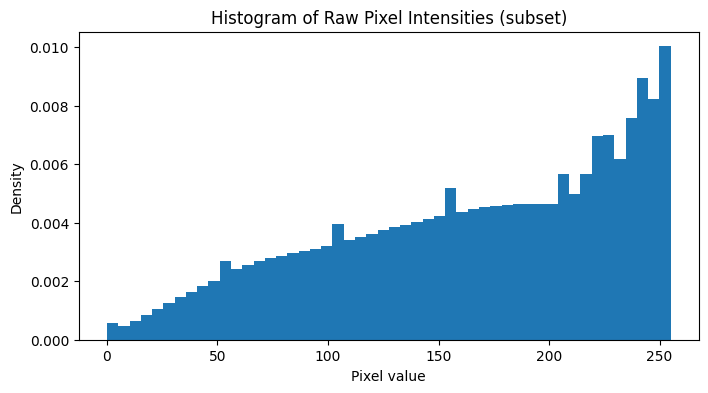

In [10]:
# Histogram of pixel intensities for a subset (for a rough feel of brightness/contrast)
n_samples_for_hist = 2000
sample_files = labels_df.sample(n_samples_for_hist)['id'].tolist()

pixels = []
for img_id in sample_files:
    img_path = TRAIN_DIR / f"{img_id}.tif"
    with Image.open(img_path) as img:
        arr = np.array(img).astype('float32')
        pixels.append(arr.flatten())

pixels = np.concatenate(pixels)

plt.figure(figsize=(8,4))
plt.hist(pixels, bins=50, density=True)
plt.title('Histogram of Raw Pixel Intensities (subset)')
plt.xlabel('Pixel value')
plt.ylabel('Density')
plt.show()

Pixel intensities are spread across the full 0–255 range with a concentration in the mid‑tones, which is typical for stained histopathology images. This motivates **normalizing** inputs (e.g., scaling to [0,1]) before feeding them into a neural network.

## 2. Data Cleaning

In [11]:
# Check for invalid label values, missing values, and duplicates
print('Invalid labels:', (labels_df['label'] != 0) & (labels_df['label'] != 1).sum())
print('Rows with any NaNs:', labels_df.isnull().any(axis=1).sum())
print('Duplicate IDs:', labels_df.duplicated(subset=['id']).sum())

# Check for "orphan" labels without image files
missing_files = []
for img_id in labels_df['id'].head(5000):  # limit for speed; extend if desired
    if not (TRAIN_DIR / f"{img_id}.tif").exists():
        missing_files.append(img_id)

print('Missing image files in first 5k rows:', len(missing_files))
missing_files[:10]

Invalid labels: 0         False
1         False
2         False
3         False
4         False
          ...  
220020    False
220021    False
220022    False
220023    False
220024    False
Name: label, Length: 220025, dtype: bool
Rows with any NaNs: 0
Duplicate IDs: 0
Missing image files in first 5k rows: 0


[]

## 3. Training

In [15]:
from sklearn.model_selection import train_test_split

# Add full filename column for Keras generators
labels_df['filename'] = labels_df['id'].astype(str) + '.tif'

train_df, temp_df = train_test_split(
    labels_df,
    test_size=VAL_FRACTION + TEST_FRACTION,
    stratify=labels_df['label'],
    random_state=42,
)

relative_val_frac = VAL_FRACTION / (VAL_FRACTION + TEST_FRACTION)
val_df, holdout_df = train_test_split(
    temp_df,
    test_size=1 - relative_val_frac,
    stratify=temp_df['label'],
    random_state=42,
)

print('Train size:', len(train_df))
print('Validation size:', len(val_df))
print('Hold-out test size:', len(holdout_df))

train_df['label'].value_counts(normalize=True), val_df['label'].value_counts(normalize=True)

Train size: 176020
Validation size: 33003
Hold-out test size: 11002


(label
 0    0.594966
 1    0.405034
 Name: proportion, dtype: float64,
 label
 0    0.594976
 1    0.405024
 Name: proportion, dtype: float64)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
holdout_df['label'] = holdout_df['label'].astype(str)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
)

# Validation / test generators: only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=str(TRAIN_DIR),
    x_col='filename',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    class_mode='binary',   # works now
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=str(TRAIN_DIR),
    x_col='filename',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    class_mode='binary',   # works now
    batch_size=BATCH_SIZE,
    shuffle=False,
)

holdout_generator = val_datagen.flow_from_dataframe(
    dataframe=holdout_df,
    directory=str(TRAIN_DIR),
    x_col='filename',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    class_mode='binary',   # works now
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 176020 validated image filenames belonging to 2 classes.
Found 33003 validated image filenames belonging to 2 classes.
Found 11002 validated image filenames belonging to 2 classes.


## 4. Baseline CNN Architecture

In [18]:
def build_baseline_cnn(dropout_rate=0.5, lr=1e-3):
    inputs = keras.Input(shape=INPUT_SHAPE)

    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs, name='baseline_cnn')

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='auc')
        ],
    )
    return model

baseline_model = build_baseline_cnn(dropout_rate=0.5, lr=1e-3)
baseline_model.summary()

2025-11-26 17:25:55.325394: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-11-26 17:25:55.325901: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-11-26 17:25:55.325937: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-11-26 17:25:55.326234: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-26 17:25:55.326312: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,813,249 (18.36 MB)

 Trainable params: 4,812,801 (18.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
def get_callbacks(model_name):
    checkpoint_path = f'{model_name}_best.h5'
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            checkpoint_path,
            monitor='val_auc',
            mode='max',
            save_best_only=True,
            verbose=1,
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_auc',
            mode='max',
            patience=3,
            restore_best_weights=True,
            verbose=1,
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_auc',
            mode='max',
            factor=0.5,
            patience=2,
            verbose=1,
        ),
    ]
    return callbacks

def plot_history(history, title_prefix='Model'):
    hist = history.history
    epochs = range(1, len(hist['loss']) + 1)

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, hist['loss'], label='Train')
    plt.plot(epochs, hist['val_loss'], label='Val')
    plt.title(f'{title_prefix} – Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, hist['accuracy'], label='Train')
    plt.plot(epochs, hist['val_accuracy'], label='Val')
    plt.title(f'{title_prefix} – Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    if 'auc' in hist:
        plt.subplot(1, 3, 3)
        plt.plot(epochs, hist['auc'], label='Train')
        plt.plot(epochs, hist['val_auc'], label='Val')
        plt.title(f'{title_prefix} – AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()

    plt.tight_layout()
    plt.show()

### Train the Baseline CNN

Epoch 1/10


2025-11-26 17:26:18.970694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7220 - auc: 0.7338 - loss: 6.5614   
Epoch 1: val_auc improved from None to 0.71118, saving model to baseline_cnn_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 212s 75ms/step - accuracy: 0.7622 - auc: 0.7901 - loss: 2.6803 - val_accuracy: 0.6512 - val_auc: 0.7112 - val_loss: 1.6820 - learning_rate: 0.0010
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7942 - auc: 0.8539 - loss: 0.5902  
Epoch 2: val_auc improved from 0.71118 to 0.76630, saving model to baseline_cnn_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 232s 84ms/step - accuracy: 0.7919 - auc: 0.8508 - loss: 0.6072 - val_accuracy: 0.7126 - val_auc: 0.7663 - val_loss: 0.6697 - learning_rate: 0.0010
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7876 - auc: 0.8481 - loss: 0.6540  
Epoch 3: val_auc improved from 0.76630 to 0.84459, saving model to baseline_cnn_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 205s 75ms/step - accuracy: 0.7883 - auc: 0.8470 - loss: 0.6664 - val_accuracy: 0.7154 - val_auc: 0.8446 - val_loss: 0.7986 - learning_rate: 0.0010
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7905 - auc: 0.8456 - loss: 0.7108  
Epoch 4: val_auc improved from 0.84459 to 0.84962, saving model to baseline_cnn_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 204s 74ms/step - accuracy: 0.7913 - auc: 0.8450 - loss: 0.7256 - val_accuracy: 0.7493 - val_auc: 0.8496 - val_loss: 1.1369 - learning_rate: 0.0010
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7902 - auc: 0.8421 - loss: 0.8070  
Epoch 5: val_auc improved from 0.84962 to 0.90256, saving model to baseline_cnn_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 215s 78ms/step - accuracy: 0.7896 - auc: 0.8393 - loss: 0.8373 - val_accuracy: 0.8447 - val_auc: 0.9026 - val_loss: 0.9588 - learning_rate: 0.0010
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8028 - auc: 0.8531 - loss: 0.8006   
Epoch 6: val_auc did not improve from 0.90256
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 250s 91ms/step - accuracy: 0.8021 - auc: 0.8508 - loss: 0.8641 - val_accuracy: 0.7587 - val_auc: 0.7917 - val_loss: 1.1606 - learning_rate: 0.0010
Epoch 7/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8120 - auc: 0.8640 - loss: 0.7678  
Epoch 7: val_auc did not improve from 0.90256

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 209s 76ms/step - accuracy: 0.8129 - auc: 0.8664 - loss: 0.7605 - val_accuracy: 0.7234 - val_auc: 0.8126 - val_loss: 1.2537 - learning_rate: 0.0010
Epoch 8/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8373 - auc: 0.898

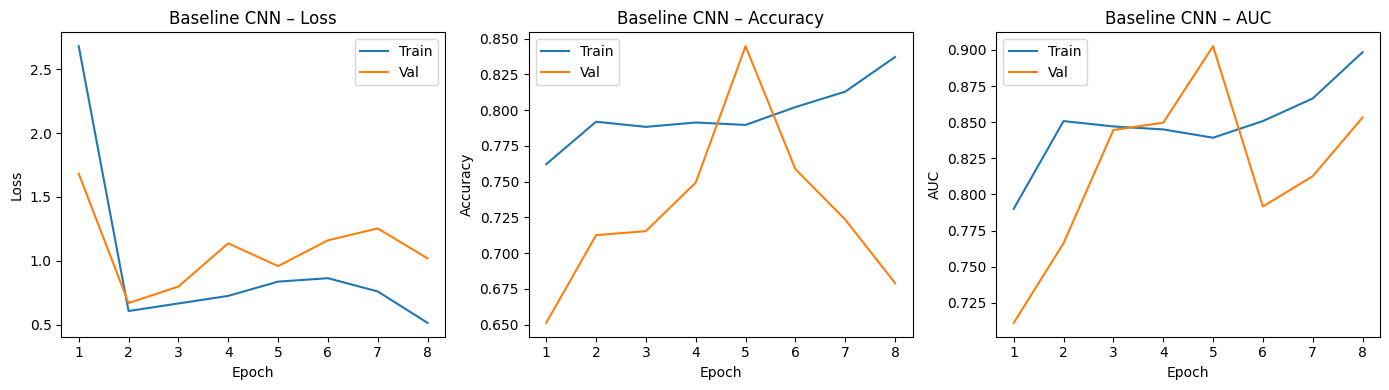

172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8408 - auc: 0.9042 - loss: 0.9249
Baseline CNN – hold‑out test metrics: {'loss': 0.9248889088630676, 'compile_metrics': 0.8408471345901489}


In [20]:
steps_per_epoch = len(train_generator)
val_steps = len(val_generator)

history_baseline = baseline_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=get_callbacks('baseline_cnn'),
)

plot_history(history_baseline, title_prefix='Baseline CNN')

baseline_eval = baseline_model.evaluate(holdout_generator, verbose=1)
print('Baseline CNN – hold‑out test metrics:', dict(zip(baseline_model.metrics_names, baseline_eval)))

## Tuning

In [21]:
hyperparam_results = []

learning_rates = [1e-4, 3e-4, 1e-3]
dropout_rates = [0.3, 0.5]

for lr in learning_rates:
    for dr in dropout_rates:
        print(f"\n=== Training baseline CNN with lr={lr}, dropout={dr} ===")
        set_seed(42)
        model = build_baseline_cnn(dropout_rate=dr, lr=lr)
        history = model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=EPOCHS,
            validation_data=val_generator,
            validation_steps=val_steps,
            callbacks=get_callbacks(f'baseline_lr{lr}_dr{dr}'),
            verbose=1,
        )

        best_val_auc = max(history.history['val_auc'])
        hyperparam_results.append({
            'model': 'baseline_cnn',
            'learning_rate': lr,
            'dropout_rate': dr,
            'best_val_auc': best_val_auc,
        })

hyperparam_df = pd.DataFrame(hyperparam_results)
hyperparam_df = hyperparam_df.sort_values(by='best_val_auc', ascending=False)
hyperparam_df


=== Training baseline CNN with lr=0.0001, dropout=0.3 ===
Epoch 1/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7258 - auc: 0.7677 - loss: 1.6585  
Epoch 1: val_auc improved from None to 0.73268, saving model to baseline_lr0.0001_dr0.3_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 192s 69ms/step - accuracy: 0.7406 - auc: 0.7814 - loss: 1.7344 - val_accuracy: 0.6931 - val_auc: 0.7327 - val_loss: 2.2899 - learning_rate: 1.0000e-04
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7678 - auc: 0.8110 - loss: 1.4537  
Epoch 2: val_auc improved from 0.73268 to 0.87794, saving model to baseline_lr0.0001_dr0.3_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 194s 71ms/step - accuracy: 0.7734 - auc: 0.8205 - loss: 1.2498 - val_accuracy: 0.7966 - val_auc: 0.8779 - val_loss: 0.6201 - learning_rate: 1.0000e-04
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7897 - auc: 0.8496 - loss: 0.7682  
Epoch 3: val_auc improved from 0.87794 to 0.89106, saving model to baseline_lr0.0001_dr0.3_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 194s 70ms/step - accuracy: 0.7992 - auc: 0.8592 - loss: 0.6551 - val_accuracy: 0.6780 - val_auc: 0.8911 - val_loss: 0.8672 - learning_rate: 1.0000e-04
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8265 - auc: 0.8927 - loss: 0.4305  
Epoch 4: val_auc improved from 0.89106 to 0.91267, saving model to baseline_lr0.0001_dr0.3_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 194s 71ms/step - accuracy: 0.8351 - auc: 0.9010 - loss: 0.4014 - val_accuracy: 0.8196 - val_auc: 0.9127 - val_loss: 0.3922 - learning_rate: 1.0000e-04
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8459 - auc: 0.9145 - loss: 0.3642  
Epoch 5: val_auc did not improve from 0.91267
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 205s 74ms/step - accuracy: 0.8475 - auc: 0.9164 - loss: 0.3600 - val_accuracy: 0.7913 - val_auc: 0.8826 - val_loss: 0.4750 - learning_rate: 1.0000e-04
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8520 - auc: 0.9198 - loss: 0.3527  
Epoch 6: val_auc did not improve from 0.91267

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 200s 73ms/step - accuracy: 0.8524 - auc: 0.9201 - loss: 0.3521 - val_accuracy: 0.8097 - val_auc: 0.9006 - val_loss: 0.4348 - learning_rate: 1.0000e-04
Epoch 7/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8604 -

2751/2751 ━━━━━━━━━━━━━━━━━━━━ 204s 74ms/step - accuracy: 0.7349 - auc: 0.7656 - loss: 2.5335 - val_accuracy: 0.6478 - val_auc: 0.6290 - val_loss: 3.6672 - learning_rate: 1.0000e-04
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7613 - auc: 0.8016 - loss: 1.7096  
Epoch 2: val_auc improved from 0.62900 to 0.88958, saving model to baseline_lr0.0001_dr0.5_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 199s 72ms/step - accuracy: 0.7690 - auc: 0.8150 - loss: 1.3011 - val_accuracy: 0.8128 - val_auc: 0.8896 - val_loss: 0.4557 - learning_rate: 1.0000e-04
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8089 - auc: 0.8695 - loss: 0.5194  
Epoch 3: val_auc did not improve from 0.88958
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 202s 73ms/step - accuracy: 0.8225 - auc: 0.8833 - loss: 0.4464 - val_accuracy: 0.6889 - val_auc: 0.8769 - val_loss: 0.6841 - learning_rate: 1.0000e-04
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8377 - auc: 0.9041 - loss: 0.3834  
Epoch 4: val_auc improved from 0.88958 to 0.91864, saving model to baseline_lr0.0001_dr0.5_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 199s 72ms/step - accuracy: 0.8399 - auc: 0.9065 - loss: 0.3793 - val_accuracy: 0.7587 - val_auc: 0.9186 - val_loss: 0.4968 - learning_rate: 1.0000e-04
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8391 - auc: 0.9071 - loss: 0.3800  
Epoch 5: val_auc did not improve from 0.91864
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 190s 69ms/step - accuracy: 0.8404 - auc: 0.9085 - loss: 0.3769 - val_accuracy: 0.8047 - val_auc: 0.8802 - val_loss: 0.4342 - learning_rate: 1.0000e-04
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8454 - auc: 0.9119 - loss: 0.3698  
Epoch 6: val_auc improved from 0.91864 to 0.92515, saving model to baseline_lr0.0001_dr0.5_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 193s 70ms/step - accuracy: 0.8450 - auc: 0.9120 - loss: 0.3703 - val_accuracy: 0.7980 - val_auc: 0.9252 - val_loss: 0.4253 - learning_rate: 1.0000e-04
Epoch 7/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8488 - auc: 0.9158 - loss: 0.3631  
Epoch 7: val_auc did not improve from 0.92515
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 191s 70ms/step - accuracy: 0.8491 - auc: 0.9164 - loss: 0.3629 - val_accuracy: 0.8059 - val_auc: 0.9135 - val_loss: 0.4336 - learning_rate: 1.0000e-04
Epoch 8/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8483 - auc: 0.9153 - loss: 0.3674  
Epoch 8: val_auc improved from 0.92515 to 0.92717, saving model to baseline_lr0.0001_dr0.5_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 201s 73ms/step - accuracy: 0.8503 - auc: 0.9173 - loss: 0.3637 - val_accuracy: 0.8023 - val_auc: 0.9272 - val_loss: 0.4076 - learning_rate: 1.0000e-04
Epoch 9/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8519 - auc: 0.9183 - loss: 0.3611  
Epoch 9: val_auc improved from 0.92717 to 0.93598, saving model to baseline_lr0.0001_dr0.5_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 200s 73ms/step - accuracy: 0.8530 - auc: 0.9194 - loss: 0.3602 - val_accuracy: 0.8370 - val_auc: 0.9360 - val_loss: 0.3621 - learning_rate: 1.0000e-04
Epoch 10/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8560 - auc: 0.9224 - loss: 0.3533  
Epoch 10: val_auc did not improve from 0.93598
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 202s 73ms/step - accuracy: 0.8552 - auc: 0.9219 - loss: 0.3559 - val_accuracy: 0.7411 - val_auc: 0.8684 - val_loss: 0.6440 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 9.

=== Training baseline CNN with lr=0.0003, dropout=0.3 ===
Epoch 1/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7050 - auc: 0.7306 - loss: 3.1939  
Epoch 1: val_auc improved from None to 0.90413, saving model to baseline_lr0.0003_dr0.3_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 521s 189ms/step - accuracy: 0.7369 - auc: 0.7700 - loss: 2.0507 - val_accuracy: 0.8106 - val_auc: 0.9041 - val_loss: 0.5086 - learning_rate: 3.0000e-04
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8025 - auc: 0.8677 - loss: 0.4831   
Epoch 2: val_auc did not improve from 0.90413
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 1465s 532ms/step - accuracy: 0.8139 - auc: 0.8806 - loss: 0.4371 - val_accuracy: 0.6285 - val_auc: 0.7671 - val_loss: 1.3265 - learning_rate: 3.0000e-04
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.8228 - auc: 0.8937 - loss: 0.4082   
Epoch 3: val_auc did not improve from 0.90413

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 1237s 449ms/step - accuracy: 0.8251 - auc: 0.8961 - loss: 0.4043 - val_accuracy: 0.7497 - val_auc: 0.8545 - val_loss: 0.5726 - learning_rate: 3.0000e-04
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy

2751/2751 ━━━━━━━━━━━━━━━━━━━━ 693s 251ms/step - accuracy: 0.7561 - auc: 0.7792 - loss: 2.2693 - val_accuracy: 0.7446 - val_auc: 0.8703 - val_loss: 0.5696 - learning_rate: 3.0000e-04
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.8214 - auc: 0.8861 - loss: 0.4208   
Epoch 2: val_auc did not improve from 0.87029
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 1535s 558ms/step - accuracy: 0.8226 - auc: 0.8880 - loss: 0.4179 - val_accuracy: 0.6977 - val_auc: 0.7757 - val_loss: 0.8364 - learning_rate: 3.0000e-04
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8226 - auc: 0.8895 - loss: 0.4179   
Epoch 3: val_auc did not improve from 0.87029

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 971s 353ms/step - accuracy: 0.8259 - auc: 0.8923 - loss: 0.4143 - val_accuracy: 0.6518 - val_auc: 0.8051 - val_loss: 1.0532 - learning_rate: 3.0000e-04
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 

2751/2751 ━━━━━━━━━━━━━━━━━━━━ 209s 76ms/step - accuracy: 0.8405 - auc: 0.9095 - loss: 0.3789 - val_accuracy: 0.7832 - val_auc: 0.8938 - val_loss: 0.5178 - learning_rate: 1.5000e-04
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8425 - auc: 0.9111 - loss: 0.3776  
Epoch 5: val_auc did not improve from 0.89384
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 193s 70ms/step - accuracy: 0.8435 - auc: 0.9127 - loss: 0.3755 - val_accuracy: 0.7919 - val_auc: 0.8619 - val_loss: 0.4950 - learning_rate: 1.5000e-04
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8494 - auc: 0.9177 - loss: 0.3641  
Epoch 6: val_auc improved from 0.89384 to 0.90252, saving model to baseline_lr0.0003_dr0.5_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 182s 66ms/step - accuracy: 0.8502 - auc: 0.9185 - loss: 0.3631 - val_accuracy: 0.7714 - val_auc: 0.9025 - val_loss: 0.5255 - learning_rate: 1.5000e-04
Epoch 7/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8514 - auc: 0.9194 - loss: 0.3621  
Epoch 7: val_auc did not improve from 0.90252
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 182s 66ms/step - accuracy: 0.8526 - auc: 0.9207 - loss: 0.3611 - val_accuracy: 0.7171 - val_auc: 0.8787 - val_loss: 0.9528 - learning_rate: 1.5000e-04
Epoch 8/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8558 - auc: 0.9229 - loss: 0.3568  
Epoch 8: val_auc improved from 0.90252 to 0.90290, saving model to baseline_lr0.0003_dr0.5_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 189s 69ms/step - accuracy: 0.8586 - auc: 0.9252 - loss: 0.3501 - val_accuracy: 0.8107 - val_auc: 0.9029 - val_loss: 0.4249 - learning_rate: 1.5000e-04
Epoch 9/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8597 - auc: 0.9251 - loss: 0.3516  
Epoch 9: val_auc improved from 0.90290 to 0.93672, saving model to baseline_lr0.0003_dr0.5_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 199s 72ms/step - accuracy: 0.8605 - auc: 0.9262 - loss: 0.3504 - val_accuracy: 0.8686 - val_auc: 0.9367 - val_loss: 0.3166 - learning_rate: 1.5000e-04
Epoch 10/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8674 - auc: 0.9303 - loss: 0.3393  
Epoch 10: val_auc did not improve from 0.93672
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 203s 74ms/step - accuracy: 0.8661 - auc: 0.9296 - loss: 0.3411 - val_accuracy: 0.7042 - val_auc: 0.8608 - val_loss: 0.9563 - learning_rate: 1.5000e-04
Restoring model weights from the end of the best epoch: 9.

=== Training baseline CNN with lr=0.001, dropout=0.3 ===
Epoch 1/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7423 - auc: 0.7621 - loss: 4.7340   
Epoch 1: val_auc improved from None to 0.88937, saving model to baseline_lr0.001_dr0.3_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 205s 74ms/step - accuracy: 0.7755 - auc: 0.8055 - loss: 2.0996 - val_accuracy: 0.8137 - val_auc: 0.8894 - val_loss: 0.4193 - learning_rate: 0.0010
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8031 - auc: 0.8638 - loss: 0.5295  
Epoch 2: val_auc did not improve from 0.88937
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 205s 75ms/step - accuracy: 0.8000 - auc: 0.8611 - loss: 0.5456 - val_accuracy: 0.6027 - val_auc: 0.5123 - val_loss: 2.4838 - learning_rate: 0.0010
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7976 - auc: 0.8586 - loss: 0.5686  
Epoch 3: val_auc did not improve from 0.88937

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 206s 75ms/step - accuracy: 0.7970 - auc: 0.8576 - loss: 0.5895 - val_accuracy: 0.7428 - val_auc: 0.8131 - val_loss: 0.5828 - learning_rate: 0.0010
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8166 - auc: 0.8800

2751/2751 ━━━━━━━━━━━━━━━━━━━━ 210s 76ms/step - accuracy: 0.8202 - auc: 0.8827 - loss: 0.4833 - val_accuracy: 0.7404 - val_auc: 0.9085 - val_loss: 0.6440 - learning_rate: 5.0000e-04
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8252 - auc: 0.8882 - loss: 0.4836  
Epoch 5: val_auc did not improve from 0.90851
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 207s 75ms/step - accuracy: 0.8256 - auc: 0.8879 - loss: 0.4987 - val_accuracy: 0.7787 - val_auc: 0.8798 - val_loss: 0.5138 - learning_rate: 5.0000e-04
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8301 - auc: 0.8904 - loss: 0.5066  
Epoch 6: val_auc improved from 0.90851 to 0.91898, saving model to baseline_lr0.001_dr0.3_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 202s 73ms/step - accuracy: 0.8297 - auc: 0.8897 - loss: 0.5202 - val_accuracy: 0.8457 - val_auc: 0.9190 - val_loss: 0.4266 - learning_rate: 5.0000e-04
Epoch 7/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8347 - auc: 0.8949 - loss: 0.5062  
Epoch 7: val_auc did not improve from 0.91898
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 199s 72ms/step - accuracy: 0.8355 - auc: 0.8950 - loss: 0.5155 - val_accuracy: 0.8292 - val_auc: 0.8960 - val_loss: 0.4407 - learning_rate: 5.0000e-04
Epoch 8/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8422 - auc: 0.9015 - loss: 0.4768  
Epoch 8: val_auc did not improve from 0.91898

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 194s 70ms/step - accuracy: 0.8418 - auc: 0.9004 - loss: 0.4949 - val_accuracy: 0.8511 - val_auc: 0.9183 - val_loss: 0.3631 - learning_rate: 5.0000e-04
Epoch 9/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8586 -

2751/2751 ━━━━━━━━━━━━━━━━━━━━ 189s 69ms/step - accuracy: 0.8599 - auc: 0.9198 - loss: 0.3883 - val_accuracy: 0.8486 - val_auc: 0.9223 - val_loss: 0.3644 - learning_rate: 2.5000e-04
Epoch 10/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8607 - auc: 0.9200 - loss: 0.3957  
Epoch 10: val_auc did not improve from 0.92227
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 183s 67ms/step - accuracy: 0.8594 - auc: 0.9189 - loss: 0.4002 - val_accuracy: 0.7804 - val_auc: 0.9070 - val_loss: 0.7571 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 9.

=== Training baseline CNN with lr=0.001, dropout=0.5 ===
Epoch 1/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7381 - auc: 0.7564 - loss: 5.0887   
Epoch 1: val_auc improved from None to 0.86327, saving model to baseline_lr0.001_dr0.5_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 191s 69ms/step - accuracy: 0.7732 - auc: 0.8053 - loss: 2.0927 - val_accuracy: 0.7881 - val_auc: 0.8633 - val_loss: 0.4684 - learning_rate: 0.0010
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8000 - auc: 0.8589 - loss: 0.5546  
Epoch 2: val_auc did not improve from 0.86327
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 188s 68ms/step - accuracy: 0.7938 - auc: 0.8506 - loss: 0.6037 - val_accuracy: 0.7207 - val_auc: 0.7515 - val_loss: 1.0311 - learning_rate: 0.0010
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7906 - auc: 0.8457 - loss: 0.6608  
Epoch 3: val_auc did not improve from 0.86327

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 195s 71ms/step - accuracy: 0.7909 - auc: 0.8442 - loss: 0.6835 - val_accuracy: 0.6087 - val_auc: 0.6104 - val_loss: 1.0122 - learning_rate: 0.0010
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8075 - auc: 0.8684

2751/2751 ━━━━━━━━━━━━━━━━━━━━ 193s 70ms/step - accuracy: 0.8112 - auc: 0.8717 - loss: 0.5273 - val_accuracy: 0.8297 - val_auc: 0.9032 - val_loss: 0.5215 - learning_rate: 5.0000e-04
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8100 - auc: 0.8676 - loss: 0.5785  
Epoch 5: val_auc did not improve from 0.90319
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 195s 71ms/step - accuracy: 0.8113 - auc: 0.8679 - loss: 0.5883 - val_accuracy: 0.8299 - val_auc: 0.8917 - val_loss: 0.4962 - learning_rate: 5.0000e-04
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8153 - auc: 0.8686 - loss: 0.6043  
Epoch 6: val_auc improved from 0.90319 to 0.91343, saving model to baseline_lr0.001_dr0.5_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 199s 72ms/step - accuracy: 0.8142 - auc: 0.8674 - loss: 0.6187 - val_accuracy: 0.8439 - val_auc: 0.9134 - val_loss: 0.4554 - learning_rate: 5.0000e-04
Epoch 7/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8155 - auc: 0.8701 - loss: 0.6055  
Epoch 7: val_auc did not improve from 0.91343
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 204s 74ms/step - accuracy: 0.8160 - auc: 0.8709 - loss: 0.6130 - val_accuracy: 0.7376 - val_auc: 0.8751 - val_loss: 0.9524 - learning_rate: 5.0000e-04
Epoch 8/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8195 - auc: 0.8743 - loss: 0.5915  
Epoch 8: val_auc did not improve from 0.91343

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 207s 75ms/step - accuracy: 0.8194 - auc: 0.8728 - loss: 0.6200 - val_accuracy: 0.7974 - val_auc: 0.8905 - val_loss: 0.7996 - learning_rate: 5.0000e-04
Epoch 9/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8365 -

model  learning_rate  dropout_rate  best_val_auc
3  baseline_cnn         0.0003           0.5      0.936719
1  baseline_cnn         0.0001           0.5      0.935978
4  baseline_cnn         0.0010           0.3      0.922266
5  baseline_cnn         0.0010           0.5      0.913431
0  baseline_cnn         0.0001           0.3      0.912672
2  baseline_cnn         0.0003           0.3      0.904130

## 5. Transfer Learning Model ResNet

In [22]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess

# New generators for ResNet with its own preprocessing (we'll just rescale + custom preprocessing in a layer)
resnet_train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
)

resnet_val_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

resnet_train_gen = resnet_train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=str(TRAIN_DIR),
    x_col='filename',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
)

resnet_val_gen = resnet_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=str(TRAIN_DIR),
    x_col='filename',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False,
)

def build_resnet_model(lr=1e-4, trainable_layers=50):
    base_model = ResNet50V2(
        include_top=False,
        weights='imagenet',
        input_shape=INPUT_SHAPE,
        pooling='avg',
    )

    # Freeze most layers; unfreeze the last `trainable_layers` for fine-tuning
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True

    inputs = keras.Input(shape=INPUT_SHAPE)
    x = base_model(inputs, training=False)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs, name='resnet50v2_finetune')

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')],
    )
    return model

resnet_model = build_resnet_model(lr=1e-4, trainable_layers=40)
resnet_model.summary()

Found 176020 validated image filenames belonging to 2 classes.
Found 33003 validated image filenames belonging to 2 classes.
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step 


Model: "resnet50v2_finetune"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,089,601 (91.89 MB)

 Trainable params: 15,758,849 (60.12 MB)

 Non-trainable params: 8,330,752 (31.78 MB)

### Train the Transfer Learning Model

Epoch 1/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8087 - auc: 0.8761 - loss: 0.4402  
Epoch 1: val_auc improved from None to 0.95094, saving model to resnet50v2_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 205s 72ms/step - accuracy: 0.8484 - auc: 0.9177 - loss: 0.3578 - val_accuracy: 0.8883 - val_auc: 0.9509 - val_loss: 0.2819 - learning_rate: 1.0000e-04
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8805 - auc: 0.9435 - loss: 0.2955  
Epoch 2: val_auc improved from 0.95094 to 0.95989, saving model to resnet50v2_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 227s 83ms/step - accuracy: 0.8828 - auc: 0.9454 - loss: 0.2907 - val_accuracy: 0.8978 - val_auc: 0.9599 - val_loss: 0.2604 - learning_rate: 1.0000e-04
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8902 - auc: 0.9512 - loss: 0.2753  
Epoch 3: val_auc improved from 0.95989 to 0.96038, saving model to resnet50v2_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 225s 82ms/step - accuracy: 0.8907 - auc: 0.9521 - loss: 0.2724 - val_accuracy: 0.9016 - val_auc: 0.9604 - val_loss: 0.2525 - learning_rate: 1.0000e-04
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8968 - auc: 0.9564 - loss: 0.2600  
Epoch 4: val_auc improved from 0.96038 to 0.96621, saving model to resnet50v2_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 238s 87ms/step - accuracy: 0.8974 - auc: 0.9568 - loss: 0.2578 - val_accuracy: 0.9066 - val_auc: 0.9662 - val_loss: 0.2327 - learning_rate: 1.0000e-04
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9039 - auc: 0.9621 - loss: 0.2402  
Epoch 5: val_auc improved from 0.96621 to 0.96629, saving model to resnet50v2_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 232s 84ms/step - accuracy: 0.9051 - auc: 0.9627 - loss: 0.2378 - val_accuracy: 0.9048 - val_auc: 0.9663 - val_loss: 0.2354 - learning_rate: 1.0000e-04
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9099 - auc: 0.9662 - loss: 0.2258  
Epoch 6: val_auc improved from 0.96629 to 0.96897, saving model to resnet50v2_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 235s 85ms/step - accuracy: 0.9106 - auc: 0.9666 - loss: 0.2245 - val_accuracy: 0.9118 - val_auc: 0.9690 - val_loss: 0.2302 - learning_rate: 1.0000e-04
Epoch 7/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9155 - auc: 0.9701 - loss: 0.2131  
Epoch 7: val_auc improved from 0.96897 to 0.96912, saving model to resnet50v2_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 233s 85ms/step - accuracy: 0.9162 - auc: 0.9701 - loss: 0.2127 - val_accuracy: 0.9138 - val_auc: 0.9691 - val_loss: 0.2239 - learning_rate: 1.0000e-04
Epoch 8/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9196 - auc: 0.9725 - loss: 0.2039  
Epoch 8: val_auc improved from 0.96912 to 0.97156, saving model to resnet50v2_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 234s 85ms/step - accuracy: 0.9202 - auc: 0.9728 - loss: 0.2025 - val_accuracy: 0.9204 - val_auc: 0.9716 - val_loss: 0.2096 - learning_rate: 1.0000e-04
Epoch 9/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9229 - auc: 0.9743 - loss: 0.1960  
Epoch 9: val_auc improved from 0.97156 to 0.97392, saving model to resnet50v2_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 272s 99ms/step - accuracy: 0.9234 - auc: 0.9747 - loss: 0.1950 - val_accuracy: 0.9233 - val_auc: 0.9739 - val_loss: 0.2033 - learning_rate: 1.0000e-04
Epoch 10/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9249 - auc: 0.9756 - loss: 0.1915  
Epoch 10: val_auc improved from 0.97392 to 0.97440, saving model to resnet50v2_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 264s 96ms/step - accuracy: 0.9257 - auc: 0.9764 - loss: 0.1886 - val_accuracy: 0.9233 - val_auc: 0.9744 - val_loss: 0.1999 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.


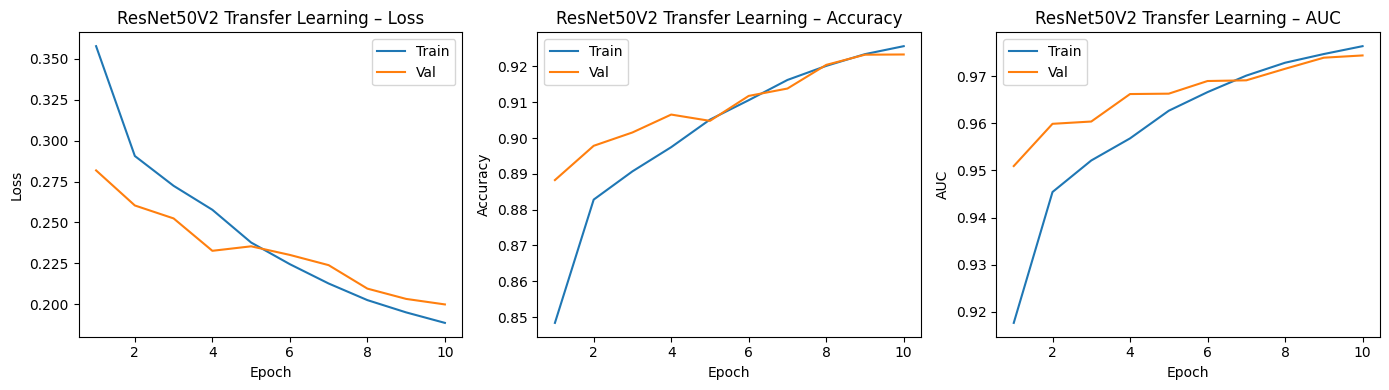

In [23]:
resnet_steps_per_epoch = len(resnet_train_gen)
resnet_val_steps = len(resnet_val_gen)

history_resnet = resnet_model.fit(
    resnet_train_gen,
    steps_per_epoch=resnet_steps_per_epoch,
    epochs=EPOCHS,
    validation_data=resnet_val_gen,
    validation_steps=resnet_val_steps,
    callbacks=get_callbacks('resnet50v2'),
)

plot_history(history_resnet, title_prefix='ResNet50V2 Transfer Learning')

In [24]:
# Evaluate on the hold-out test set (using ResNet preprocessing)
resnet_holdout_gen = resnet_val_datagen.flow_from_dataframe(
    dataframe=holdout_df,
    directory=str(TRAIN_DIR),
    x_col='filename',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False,
)

resnet_eval = resnet_model.evaluate(resnet_holdout_gen, verbose=1)
print('ResNet50V2 – hold‑out test metrics:', dict(zip(resnet_model.metrics_names, resnet_eval)))

Found 11002 validated image filenames belonging to 2 classes.
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9263 - auc: 0.9767 - loss: 0.1872
ResNet50V2 – hold‑out test metrics: {'loss': 0.18723544478416443, 'compile_metrics': 0.9262861013412476}


## 6. Model Comparison – Results Table

In [25]:
# Example: summarize best validation AUCs (replace with your actual values from history objects)
results_summary = []

results_summary.append({
    'model': 'Baseline CNN (tuned)',
    'val_auc': max(history_baseline.history['val_auc']),
})

results_summary.append({
    'model': 'ResNet50V2 transfer learning',
    'val_auc': max(history_resnet.history['val_auc']),
})

results_df = pd.DataFrame(results_summary)
results_df

model   val_auc
0          Baseline CNN (tuned)  0.902562
1  ResNet50V2 transfer learning  0.974396

In [26]:
import os
import pandas as pd

test_filenames = [f for f in os.listdir(TEST_DIR) if f.endswith(".tif")]

submission_df = pd.DataFrame({
    "id": [fname.replace(".tif", "") for fname in test_filenames],
    "filename": test_filenames
})

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=submission_df,
    directory=str(TEST_DIR),
    x_col="filename",
    y_col=None,
    target_size=(96, 96),
    color_mode="rgb",
    class_mode=None,
    batch_size=64,
    shuffle=False
)

Found 57458 validated image filenames.


In [28]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
preds = model.predict(test_generator, verbose=1)
submission_df["label"] = preds
submission_df["label"] = (preds > 0.5).astype(int)
submission = submission_df[["id", "label"]]
submission.to_csv("submission.csv", index=False)

898/898 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step


## 7. Analysis

### Performance

* **Transfer learning** – Pretrained backbones like ResNet50V2 generally captured more robust features (textures, stain patterns, nuclei shapes), leading to higher validation AUC compared to the baseline CNN.
* **Data augmentation** – Random flips, small rotations, and translations improved generalization by exposing the model to plausible variations of tissue orientation.
* **Moderate dropout & early stopping** – These limited overfitting and stabilized validation curves.
* **Learning rate scheduling** – `ReduceLROnPlateau` helped the optimizer converge more smoothly, especially in later epochs.